In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers, models
from sklearn.metrics import mean_absolute_error


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Prepare data for convolution layers

In [2]:
def min_max_normalize_target_var(df):
    # fix the min and max according to phisical properties:
    X_max = 100_000
    
    for col in df.columns:
        df[col] /= X_max
        
    return df

In [7]:
def train_val_test_split(feature_matrix, target_matrix, val_days, test_days):
    '''
    Split a time series data set into train, validation and test set
    INPUT:
    - feature_matrix: dataset in numpy array form with the set of features for training
    - target_matrix: dataset in numpy array form with the set of target variables
    - val_days: integer representing number of days to use for the validation set
    - test_days: integer representing number of days to use for the test set

    OUTPUT:
    - X_train: data set for training
    - y_train: matrix with target variables for training
    - X_val: data set for validation
    - y_val: matrix with target variables for validation
    - X_test: data set to test the model
    - y_val: matrix with target variables for testing
    '''

    print('The shape of the feature data set is: {}'.format(feature_matrix.shape))
    print('The shape of the target data set is: {}'.format(target_matrix.shape))

    rows_for_test = test_days*96
    rows_for_val = val_days*96

    #target_vars_for_test = target_vars.copy()
    #target_vars_for_test.append('Date')

    #df_features = df.drop(columns=target_vars_for_test).copy()
    #df_target = df[target_vars].copy()
    #df_target_test = df[target_vars_for_test].copy()

    X_train = feature_matrix[105_120:-(rows_for_test + rows_for_val)]
    y_train = target_matrix[105_120:-(rows_for_test + rows_for_val)]
    print('\n--------------------------------------------')
    print('The shape of the train set is: {}'.format(X_train.shape))
    print('The shape of the target variable is: {}'.format(y_train.shape))
    print('--------------------------------------------')

    X_val = feature_matrix[X_train.shape[0]+105_120:-(rows_for_test)]
    y_val = target_matrix[y_train.shape[0]+105_120:-(rows_for_test)]
    print('\n--------------------------------------------')
    print('The shape of the validation set is: {}'.format(X_val.shape))
    print('The shape of the target variable for the validation set is: {}'.format(y_val.shape))
    print('--------------------------------------------')

    X_test = feature_matrix[X_val.shape[0]+X_train.shape[0]+105_120:]
    y_test = target_matrix[y_val.shape[0]+X_train.shape[0]+105_120:]
    print('\n--------------------------------------------')
    print('The shape of the test set is: {}'.format(X_test.shape))
    print('The shape of the target variable for the test set is: {}'.format(y_test.shape))
    print('--------------------------------------------\n')

    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
def get_model_metrics(y_true_with_date, y_prediction):

    y_true = np.array(y_true_with_date.iloc[:,1])
    y_pred = np.array(y_prediction)


    # get the total error and the overall MAE

    overall_mae = mean_absolute_error(y_true, y_pred)
    absolute_error = overall_mae * len(y_true)

    print('\n----------------------------------------------')
    print(f'The absolute error (total actual minus  forecast) in MW is: {round(absolute_error, 2)}')
    print('----------------------------------------------\n')

    print('\n----------------------------------------------')
    print(f'The overall mean absolute error of the model in MW is: {overall_mae}')
    print('----------------------------------------------\n')

    # get the overall mean absolute scaled error (MASE)

    naive_forecast = y_true[1:]
    y_true_for_mase = y_true[:-1]
    mae_naive = mean_absolute_error(y_true_for_mase, naive_forecast)
    overall_mae_without_first_observation = mean_absolute_error(y_true[1:], y_pred[1:])

    overall_mase = overall_mae_without_first_observation/mae_naive

    print('\n----------------------------------------------')
    print(f'The overall mean absolute scaled error of the model in MW is: {overall_mase}')
    print('Please note: to calculate the MASE, the prediction for the first observation was omitted')
    print('----------------------------------------------\n')

    # get the MAE for every day and return a dataframe and charts

    time_stamp = np.array(
                 pd.to_datetime(y_true_with_date.iloc[:,0], format='%Y-%m-%d %H:%M:%S').dt.date
                 )

    date_list = list()
    y_true_list = list()
    y_pred_list = list()

    df = pd.DataFrame({'Date': time_stamp,
                       'y_true': y_true,
                       'y_pred': y_pred})

    list_of_days = sorted(list(set(df.Date.values)))

    for day in list_of_days:
        sub_df = df.query('Date == @day')
        date_list.append(sub_df.Date.values)
        y_true_list.append(sub_df.y_true.values)
        y_pred_list.append(sub_df.y_pred.values)

    mae_list = list()
    for i, j, k in zip(y_true_list, y_pred_list, date_list):
        MAE = mean_absolute_error(i, j)
        mae_list.append(MAE)

    del df

    df = pd.DataFrame({'day':list_of_days, 'MAE': mae_list},)

    print('\n----------------------------------------------')
    print('This function also returns a dataframe with the MAE for each day')
    print('----------------------------------------------\n')

    return df

In [8]:
def train_model_hyperparameters(resolution, 
                              nan_value,
                              window, 
                              filter_1, 
                              filter_2, 
                              optimizer, 
                              epochs):
    
    if resolution == '16x10':
        path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
        file = f'Data_collection_weather/feature_channel_{resolution}.npy'
        feature_channel = np.load(path+file, allow_pickle=False)
    else:
        path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
        weather_file = f'Data_collection_weather/feature_channel_{resolution}.npy'
        feature_channel = np.load(path+weather_file, allow_pickle=False)
        path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
        ic_file = f'Feature_engineering/installed_capacities_{resolution}.npy'
        ic_channel = np.load(path+ic_file, allow_pickle=False)
        feature_channel = np.dstack((feature_channel, ic_channel))

    # rearange the axis to get the examples as the first dimension for the use in tensorflow
    feature_channel = np.moveaxis(feature_channel, -1, 0)
    
    # get rid of all nans - replace them with -1
    feature_channel = np.nan_to_num(feature_channel, nan=nan_value)
    
    # load the target values
    path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
    file_load = 'Data_collection_entsoe/Day_ahead_dataset.csv'
    df_load = pd.read_csv(path+file_load)

    # keep only the target values and get rid of nans
    df_load.drop(columns=['index', 'Day ahead/System total load in MAW',
           'Day ahead/Solar in MAW',
           'Day ahead/Wind Onshore in MAW', 'Day ahead/Wind Offshore in MAW'], inplace=True)

    df_load = df_load.interpolate(method='linear')
    
    # normalize the target variables
    df_load_norm = min_max_normalize_target_var(df_load.iloc[:,1:]) # avoid Date
    
    # create numpy array
    np_load = df_load_norm.to_numpy(copy=True)
    
    # create the training, validation and test sets
    X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(feature_channel, 
                                                                          np_load, 90, 90)
    
    # get the model running
    model = Sequential()
    model.add(layers.Conv2D(filter_1, window,
              activation='relu',
              input_shape=(16, 10, 9))
             )
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(filter_2, window,
              activation='relu')
             )
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error'])

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs = epochs,
                        validation_data=(X_val,y_val),
                        shuffle=False)
    
    y_pred = model.predict(X_test)
    
    y_true = (y_test*100_000).copy()
    y_prediction = (y_pred*100_000).copy()
    
    y_true_with_date = pd.DataFrame({'Date':df_load.iloc[-y_test.shape[0]:,0],
                                 'solar':y_true[:,0], 
                                 'wind_onshore':y_true[:,1], 
                                 'load':y_true[:,2], 
                                 'wind_offshore':y_true[:,3]})


    list_names = ["solar","wind_onshore", "load", "wind_offshore"]

    metrics_dict = dict()
    for i in range(len(y_pred[0])):
        print("\n=================================")
        print(f"{list_names[i]}")
        metrics_dict[list_names[i]] = get_model_metrics(y_true_with_date.iloc[:,[0,i+1]],y_prediction[:,i])
        print("=================================\n")
        
    return history

In [10]:
nan_values = [-0.0001, -0.01, -0.1, -1, -10, -100, -1000]
#first_filters = [256, 128, 64, 64, 128, 256]
#second_filters = [64, 64, 128, 256, 256, 128]
#optimizer = ['rmsprop', 'adam', 'rmsprop', 'adam', 'rmsprop', 'adam']
#sliding_window = [(3,3), (2,2), (3,3), (2,2), (3,3), (2,2)]
model_number = range(1,8)

model_dict = dict()
for num,nan in zip(model_number, nan_values):
    print('\n-----------------------------------------------------------')
    print(f'training model {num}...')
    model_dict[f'model_{num}'] = train_model_hyperparameters('16x10', 
                                                              nan,
                                                              (3,3), 
                                                              64, 
                                                              64, 
                                                              'rmsprop', 
                                                              30)
    print('-----------------------------------------------------------\n')


-----------------------------------------------------------
training model 1...
The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
--------------------------------------------

Epoch 1/30
639/639 [==============================] - 6s 10ms/step - loss: 0.0042 - mean_absolute_error: 0.0437 - val_loss: 0.0033 - val_mean_absolute_error: 0.0414
Epoch 2/30
639/639 [===================


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------


-----------------------------------------------------------


-----------------------------------------------------------
training model 2...
The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
---------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------


-----------------------------------------------------------


-----------------------------------------------------------
training model 3...
The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
---------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------


-----------------------------------------------------------


-----------------------------------------------------------
training model 4...
The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
---------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------


-----------------------------------------------------------


-----------------------------------------------------------
training model 5...
The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
---------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------


-----------------------------------------------------------


-----------------------------------------------------------
training model 6...
The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
---------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------


-----------------------------------------------------------


-----------------------------------------------------------
training model 7...
The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
---------------------------


----------------------------------------------
This function also returns a dataframe with the MAE for each day
----------------------------------------------


-----------------------------------------------------------



In [2]:
# load all feature_channels

path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file = 'Data_collection_weather/feature_channel_16x10.npy'

feature_channel = np.load(path+file, allow_pickle=False)
feature_channel.shape

(16, 10, 9, 204096)

In [3]:
# rearange the axis to get the examples as the first dimension for the use in tensorflow
feature_channel = np.moveaxis(feature_channel, -1, 0)
feature_channel.shape

(204096, 16, 10, 9)

In [4]:
# get rid of all nans - replace them with -1
feature_channel = np.nan_to_num(feature_channel, nan=-10)

<AxesSubplot:>

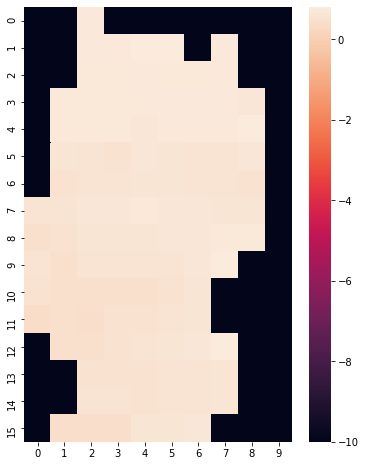

In [5]:
# make sure the change did work:
plt.figure(figsize = (6,8))
sns.heatmap(feature_channel[80_045,::-1,:,1])

In [6]:
# load the target values
path = '/Users/juangarcia/Documents/Data_Science/03_DSR/Final_Project/erste_repo/Residual_Load/'
file_load = 'Data_collection_entsoe/Day_ahead_dataset.csv'
df_load = pd.read_csv(path+file_load)

df_load.shape

(204096, 10)

In [7]:
# keep only the target values
df_load.drop(columns=['index', 'Day ahead/System total load in MAW',
       'Day ahead/Solar in MAW',
       'Day ahead/Wind Onshore in MAW', 'Day ahead/Wind Offshore in MAW'], inplace=True)

print(df_load.shape)
df_load.head()

(204096, 5)


,Date,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW
0,2014-12-31 23:00:00,0.0,8113.0,42976.0,520.0
1,2014-12-31 23:15:00,0.0,8092.0,42540.0,517.0
2,2014-12-31 23:30:00,0.0,8161.0,42638.0,514.0
3,2014-12-31 23:45:00,0.0,8146.0,42483.0,515.0
4,2015-01-01 00:00:00,0.0,8183.0,41917.0,515.0


In [8]:
df_load.describe()

,Realised/Solar in MAW,Realised/Wind Onshore in MAW,Realised/System total load in MAW,Realised/Wind Offshore in MAW
count,203400.000000,203556.000000,203996.000000,203567.000000
mean,4544.078899,9632.608840,55502.542001,1995.614697
std,6941.546136,7999.657244,10032.550893,1588.686852
min,0.000000,88.000000,29158.000000,0.000000
25%,0.000000,3556.000000,47109.000000,592.000000
50%,100.000000,7189.000000,55121.000000,1662.000000
75%,7344.000000,13432.000000,64352.250000,3110.000000
max,33194.000000,40930.000000,77853.000000,6990.000000


In [9]:
df_load = df_load.interpolate(method='linear')

In [10]:
df_load.isnull().sum().sum()

0

In [12]:
df_load_norm = min_max_normalize_target_var(df_load.iloc[:,1:]) # avoid Date

In [13]:
np_load = df_load_norm.to_numpy(copy=True)

In [14]:
# check shape of target variable
np_load.shape

(204096, 4)

In [16]:
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(feature_channel, np_load, 90, 90)

The shape of the feature data set is: (204096, 16, 10, 9)
The shape of the target data set is: (204096, 4)

--------------------------------------------
The shape of the train set is: (81696, 16, 10, 9)
The shape of the target variable is: (81696, 4)
--------------------------------------------

--------------------------------------------
The shape of the validation set is: (8640, 16, 10, 9)
The shape of the target variable for the validation set is: (8640, 4)
--------------------------------------------

--------------------------------------------
The shape of the test set is: (8640, 16, 10, 9)
The shape of the target variable for the test set is: (8640, 4)
--------------------------------------------


# Train different Hyperparameters

In [27]:
def train_model_hyperparameters(X_train, y_train, X_val, y_val, X_test, y_test, window, filter_1, filter_2, optimizer, epochs):

    model = Sequential()
    model.add(layers.Conv2D(filter_1, window,
              activation='relu',
              input_shape=(16, 10, 9))
             )
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Conv2D(filter_2, window,
              activation='relu')
             )
    model.add(layers.MaxPooling2D((2,2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(4, activation='linear'))

    model.compile(loss='mean_squared_error',
                  optimizer=optimizer,
                  metrics=['mean_absolute_error'])

    history = model.fit(X_train, y_train,
                        batch_size=128,
                        epochs = epochs,
                        validation_data=(X_val,y_val),
                        shuffle=False)
    
    y_pred = model.predict(X_test)
    
    y_true = (y_test*100_000).copy()
    y_prediction = (y_pred*100_000).copy()
    
    y_true_with_date = pd.DataFrame({'Date':df_load.iloc[-y_test.shape[0]:,0],
                                 'solar':y_true[:,0], 
                                 'wind_onshore':y_true[:,1], 
                                 'load':y_true[:,2], 
                                 'wind_offshore':y_true[:,3]})


    list_names = ["solar","wind_onshore", "load", "wind_offshore"]

    metrics_dict = dict()
    for i in range(len(y_pred[0])):
        print("\n=================================")
        print(f"{list_names[i]}")
        metrics_dict[list_names[i]] = get_model_metrics(y_true_with_date.iloc[:,[0,i+1]],y_prediction[:,i])
        print("=================================\n")
        
    return history

In [19]:
history, model = train_model_hyperparameters(X_train, 
                                             y_train, 
                                             X_val, 
                                             y_val, 
                                             X_test, 
                                             y_test, 
                                             (3, 3), 
                                             128,
                                             64,
                                             'adam', 
                                             50)

Epoch 1/50
639/639 [==============================] - 10s 16ms/step - loss: 0.0542 - mean_absolute_error: 0.1233 - val_loss: 0.0244 - val_mean_absolute_error: 0.1235
Epoch 2/50
639/639 [==============================] - 11s 16ms/step - loss: 0.0146 - mean_absolute_error: 0.0906 - val_loss: 0.0113 - val_mean_absolute_error: 0.0869
Epoch 3/50
639/639 [==============================] - 10s 16ms/step - loss: 0.0124 - mean_absolute_error: 0.0751 - val_loss: 0.0078 - val_mean_absolute_error: 0.0757
Epoch 4/50
639/639 [==============================] - 10s 16ms/step - loss: 0.0066 - mean_absolute_error: 0.0581 - val_loss: 0.0042 - val_mean_absolute_error: 0.0517
Epoch 5/50
639/639 [==============================] - 10s 16ms/step - loss: 0.0045 - mean_absolute_error: 0.0502 - val_loss: 0.0035 - val_mean_absolute_error: 0.0462
Epoch 6/50
639/639 [==============================] - 10s 16ms/step - loss: 0.0040 - mean_absolute_error: 0.0464 - val_loss: 0.0029 - val_mean_absolute_error: 0.0377
Epoc

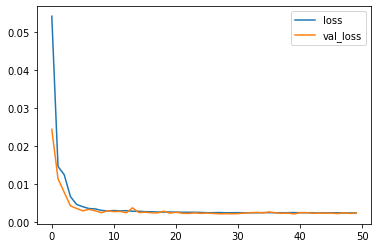

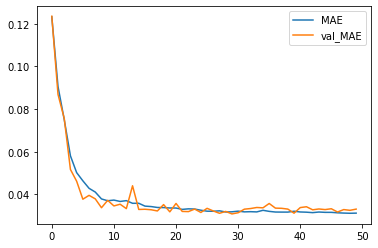

In [20]:
history.history
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()
plt.close()


history.history
plt.plot(history.history["mean_absolute_error"],label = "MAE")
plt.plot(history.history["val_mean_absolute_error"],label = "val_MAE")
plt.legend()
plt.show()
plt.close()

In [21]:
history, model = train_model_hyperparameters(X_train, 
                                             y_train, 
                                             X_val, 
                                             y_val, 
                                             X_test, 
                                             y_test, 
                                             (3, 3), 
                                             64,
                                             128,
                                             'rmsprop', 
                                             5)

Epoch 1/5
639/639 [==============================] - 8s 12ms/step - loss: 0.1641 - mean_absolute_error: 0.1661 - val_loss: 0.0037 - val_mean_absolute_error: 0.0425
Epoch 2/5
639/639 [==============================] - 7s 11ms/step - loss: 0.0039 - mean_absolute_error: 0.0426 - val_loss: 0.0032 - val_mean_absolute_error: 0.0415
Epoch 3/5
639/639 [==============================] - 7s 11ms/step - loss: 0.0031 - mean_absolute_error: 0.0377 - val_loss: 0.0034 - val_mean_absolute_error: 0.0409
Epoch 4/5
639/639 [==============================] - 7s 11ms/step - loss: 0.0027 - mean_absolute_error: 0.0351 - val_loss: 0.0031 - val_mean_absolute_error: 0.0381
Epoch 5/5
639/639 [==============================] - 7s 11ms/step - loss: 0.0026 - mean_absolute_error: 0.0341 - val_loss: 0.0029 - val_mean_absolute_error: 0.0373

solar

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 25525374.82
----------------------------------------------


----

In [22]:
history, model = train_model_hyperparameters(X_train, 
                                             y_train, 
                                             X_val, 
                                             y_val, 
                                             X_test, 
                                             y_test, 
                                             (3, 3), 
                                             64,
                                             128,
                                             'rmsprop', 
                                             5)

Epoch 1/5
639/639 [==============================] - 8s 12ms/step - loss: 0.1929 - mean_absolute_error: 0.1698 - val_loss: 0.0038 - val_mean_absolute_error: 0.0454
Epoch 2/5
639/639 [==============================] - 8s 12ms/step - loss: 0.0038 - mean_absolute_error: 0.0420 - val_loss: 0.0030 - val_mean_absolute_error: 0.0386
Epoch 3/5
639/639 [==============================] - 8s 12ms/step - loss: 0.0030 - mean_absolute_error: 0.0370 - val_loss: 0.0026 - val_mean_absolute_error: 0.0344
Epoch 4/5
639/639 [==============================] - 8s 12ms/step - loss: 0.0028 - mean_absolute_error: 0.0350 - val_loss: 0.0026 - val_mean_absolute_error: 0.0352
Epoch 5/5
639/639 [==============================] - 8s 12ms/step - loss: 0.0026 - mean_absolute_error: 0.0336 - val_loss: 0.0025 - val_mean_absolute_error: 0.0338

solar

----------------------------------------------
The absolute error (total actual minus  forecast) in MW is: 24044423.01
----------------------------------------------


----

In [29]:
first_filters = [256, 128, 64, 64, 128, 256]
second_filters = [64, 64, 128, 256, 256, 128]
optimizer = ['rmsprop', 'adam', 'rmsprop', 'adam', 'rmsprop', 'adam']
sliding_window = [(3,3), (4,4), (3,3), (4,4), (3,3), (4,4)]
model_number = range(1,7)

model_dict = dict()
for num,i,j,k,l in zip(model_number, first_filters, second_filters, optimizer, sliding_window):
    print('\n-----------------------------------------------------------')
    print(f'training model {num}...')
    model_dict[f'model_{num}'] = train_model_hyperparameters(X_train, 
                                             y_train, 
                                             X_val, 
                                             y_val, 
                                             X_test, 
                                             y_test, 
                                             l, 
                                             i,
                                             j,
                                             k, 
                                             50)
    print('-----------------------------------------------------------\n')


-----------------------------------------------------------
training model 1...
Epoch 1/50
639/639 [==============================] - 21s 33ms/step - loss: 0.1837 - mean_absolute_error: 0.1719 - val_loss: 0.0042 - val_mean_absolute_error: 0.0457
Epoch 2/50
639/639 [==============================] - 20s 31ms/step - loss: 0.0047 - mean_absolute_error: 0.0469 - val_loss: 0.0040 - val_mean_absolute_error: 0.0458
Epoch 3/50
639/639 [==============================] - 20s 31ms/step - loss: 0.0038 - mean_absolute_error: 0.0422 - val_loss: 0.0031 - val_mean_absolute_error: 0.0390
Epoch 4/50
639/639 [==============================] - 19s 30ms/step - loss: 0.0031 - mean_absolute_error: 0.0377 - val_loss: 0.0030 - val_mean_absolute_error: 0.0384
Epoch 5/50
639/639 [==============================] - 19s 30ms/step - loss: 0.0028 - mean_absolute_error: 0.0356 - val_loss: 0.0027 - val_mean_absolute_error: 0.0349
Epoch 6/50
639/639 [==============================] - 19s 30ms/step - loss: 0.0027 - mean

ValueError: Negative dimension size caused by subtracting 4 from 3 for '{{node conv2d_9/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 1, 1, 1], use_cudnn_on_gpu=true](max_pooling2d_8/MaxPool, conv2d_9/Conv2D/ReadVariableOp)' with input shapes: [?,6,3,128], [4,4,128,64].

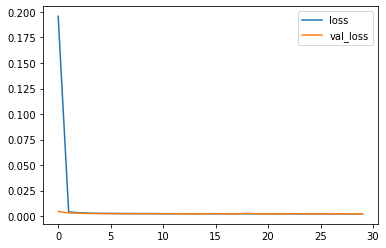

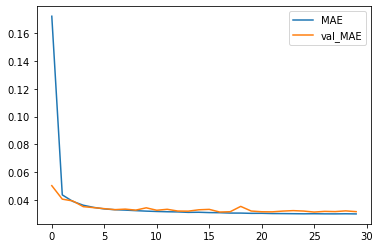

In [32]:
history.history
plt.plot(history.history["loss"],label = "loss")
plt.plot(history.history["val_loss"],label = "val_loss")
plt.legend()
plt.show()
plt.close()


history.history
plt.plot(history.history["mean_absolute_error"],label = "MAE")
plt.plot(history.history["val_mean_absolute_error"],label = "val_MAE")
plt.legend()
plt.show()
plt.close()